<a href="https://colab.research.google.com/github/rohit-447/Py-Torch-Learning/blob/main/CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#@title Loding Modules
import torch
from torch import nn
import torchvision
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
torch.__version__

'2.6.0+cu124'

In [13]:
#@title DataLoader

#Downloading and transforming data into tensor
#Train Data
train_data=FashionMNIST(
    root='data',
    download=True,
    transform=ToTensor(),
    train=True
)

#Test Data
test_data=FashionMNIST(
    root='data',
    download=True,
    transform=ToTensor(),
    train=False
)

print(f"\nTrain Data:{len(train_data)}\nTest Data:{len(test_data)}")



Train Data:60000
Test Data:10000


Shape of the image:torch.Size([1, 28, 28])


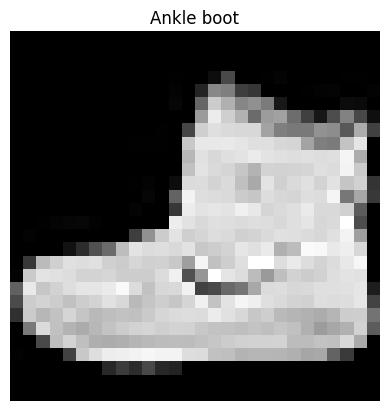

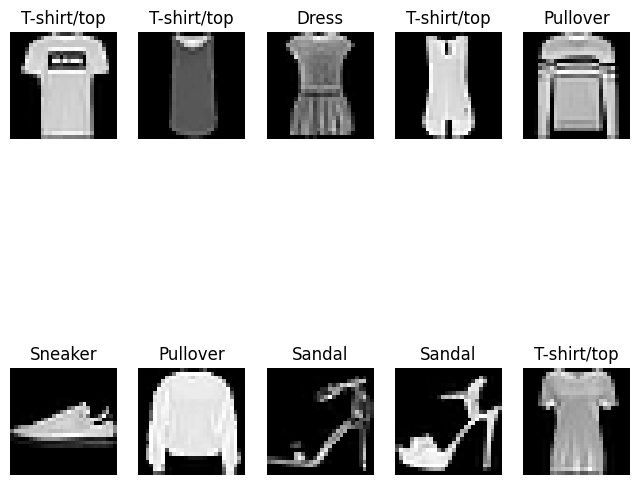

In [14]:
#@title Visulisation of Data

#getting the class of the data
class_idx=FashionMNIST.classes

#displaying a single iamge
img,label=train_data[0]
plt.imshow(img.squeeze(), cmap="grey")
plt.title(class_idx[label])
plt.axis(False)

#displying the multiple images
random_idx=torch.randint(0,len(train_data),size=[1])
plt.figure(figsize=(8,8))
rows=2
cols=5
for i in range(1,rows*cols+1):
  img,label=train_data[i]
  plt.subplot(rows,cols,i)
  plt.imshow(img.squeeze(), cmap="grey")
  plt.title(class_idx[label])
  plt.axis(False)

print(f"Shape of the image:{img.shape}")

In [15]:
#@title Device Agonistic Code
device="cuda" if torch.cuda.is_available() else "cpu"
print(f'You are on device: {device}')

You are on device: cpu


In [16]:
#@title DataLoader

#from torch.utils.data import DataLoader
BATCH_SIZE=32
train_dataloader=DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader=DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

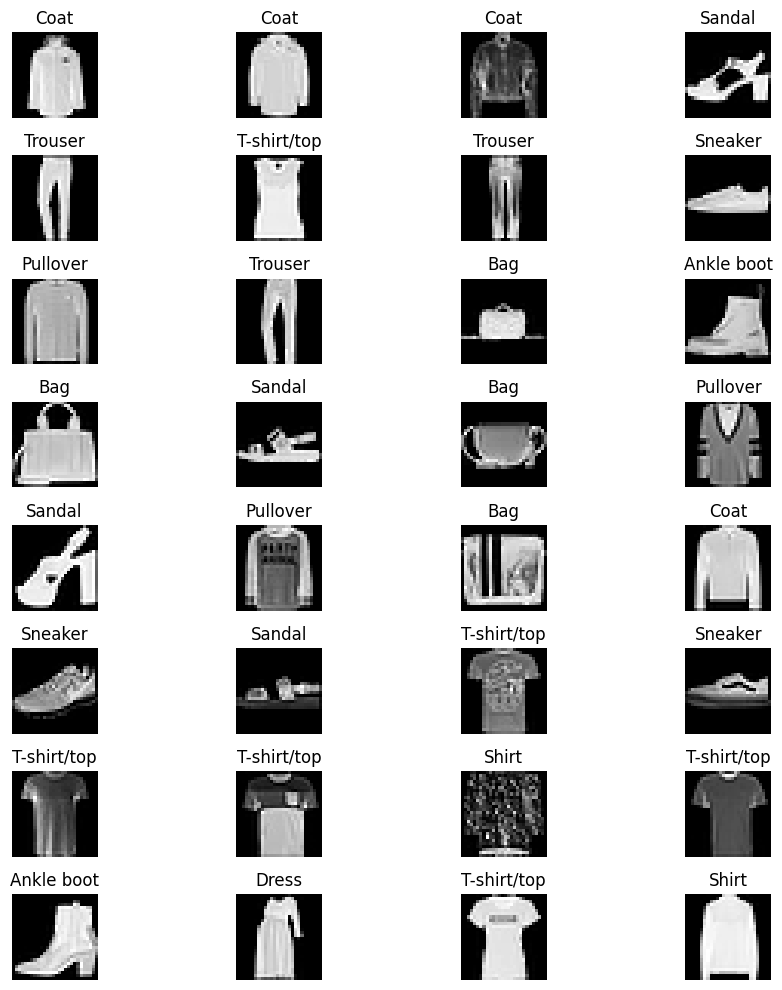

In [17]:
#@title Visulaisation of data in dataloader
plt.figure(figsize=(10,10))
rows=8
cols=4
# Get a batch of images and labels
images, labels = next(iter(train_dataloader))

for i in range(rows*cols):
  plt.subplot(rows, cols, i+1)
  plt.imshow(images[i].squeeze(), cmap="grey")
  plt.title(class_idx[labels[i]])
  plt.axis(False)

plt.tight_layout()
plt.show()

In [18]:
#@title Model using CNN
class MNISTModel(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               ouput_shape:int):

    super().__init__()
    #layer1
    self.layer_stack_1=nn.Sequential(

        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=2,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=2,
                  padding=1),
        nn.MaxPool2d(kernel_size=2, stride=2))

    #Layer 2
    self.layer_stack_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=2,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2))

    #layer 3
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*1*1,
                  out_features=ouput_shape))

  def forward(self, x: torch.Tensor):
        x = self.layer_stack_1(x)
        x = self.layer_stack_2(x)
        x = self.classifier(x)
        return x

model=MNISTModel(input_shape=1,
                 hidden_units=10,
                 ouput_shape=len(class_idx)).to(device)

In [19]:
#@title Optimizer Loss fn and Accuracy Score
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model.parameters(), lr=0.1)
def acc_fn(y_true, y_pred):
  correct=torch.eq(y_true, y_pred).sum().item()
  acc=(correct/len(y_pred))*100

In [25]:
#@title Training and Testing Loop
from tqdm.auto import tqdm
EPOCH=32
for epoch in tqdm(range(EPOCH)):
  train_loss=0
  test_loss=0
  model.train()

  for batch, (X,y) in enumerate(train_dataloader):
    X,y = X.to(device), y.to(device)


    #forward Pass
    y_pred=model(X)

    #loss
    loss=loss_fn(y_pred,y)
    train_loss+=loss.item()

    #optimize the zero grad
    optimizer.zero_grad()

    #loss backward
    loss.backward()

    #step optimizer
    optimizer.step()

    if batch %400==0:
      print(f"Looked at {batch*len(X)}/ {len(train_dataloader.dataset)} Samples")

  train_loss/=len(test_dataloader)
  model.eval()
  test_acc=0
  test_loss=0

  with torch.inference_mode():
    for X,y in train_dataloader:
      X, y = X.to(device), y.to(device)
      test_pred=model(X)
      test_loss+=loss_fn(test_pred, y)
    # test_acc=acc_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
    test_loss/=len(test_dataloader)
  print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.2f}%\n")

  0%|          | 0/32 [00:00<?, ?it/s]

Looked at 0/ 60000 Samples
Looked at 12800/ 60000 Samples
Looked at 25600/ 60000 Samples
Looked at 38400/ 60000 Samples
Looked at 51200/ 60000 Samples
Train loss: 2.31904 | Test loss: 2.37%

Looked at 0/ 60000 Samples
Looked at 12800/ 60000 Samples
Looked at 25600/ 60000 Samples
Looked at 38400/ 60000 Samples
Looked at 51200/ 60000 Samples
Train loss: 2.31045 | Test loss: 2.17%

Looked at 0/ 60000 Samples
Looked at 12800/ 60000 Samples
Looked at 25600/ 60000 Samples
Looked at 38400/ 60000 Samples
Looked at 51200/ 60000 Samples


KeyboardInterrupt: 

In [ ]:
from tqdm.auto import tqdm

EPOCHS = 32

for epoch in tqdm(range(EPOCHS)):
    model.train()
    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Compute loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)

    # Evaluation
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Accuracy
            predicted = test_pred.argmax(dim=1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    test_loss /= len(test_dataloader)
    test_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%\n")
